# Outline<a class = "anchor" id = 'outline'>
   [1. Background](#background)<br>
   
   [2. Data Section](#data)<br>
   - [Step 1: Import Package Dependencies](#package)<br>
   - [Step 2: Import Data](#import)<br>
   - [Step 3: Clean Data](#clean)<br>
   - [Step 4: Train/Test Split](#split)<br>
   
   [3. Building Model](#model)<br>
   - [Step 1: Model of numerical variables](#numerical)
       - [1-1: Bayes Naive](#1-1)<br>
       - [1-2: Logistic Regression](#1-2)<br>
<br>
   - [Step 2: Model of textual features](#text)
       - [2-1: Bag of words + N-gram](#2-1)<br>
       - [2-2: TF-IDF (Term Frequency - Inverse Document Frequency)](#2-2)<br>
<br>
   - [Step 3: Model incorporating both numerical and textual features](#both)<br>
       - [3-1: Bayes Naive](#3-1)<br>
       - [3-2: Logistic Regression](#3-2)<br>
       - [3-3: Comparison Summary](#3-3)<br>
<br>
   - [Step 4: LDA](#LDA)

# Background<a class = "anchor" id = 'background'>
   [Go to Top](#outline)

#### **Dataset:**
Dataset includes 3,000 songs and their information on Spotify.
Target Variable: ‘has_listenership’ (binary)
Kaggle dataset reference: Spotify Songs
https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs
<br>
#### **Purpose:**
I will analyze the dataset in four steps:<br>

> First, I will analyze the relationship between target variables and **numerical variables**.<br>
Secondly, I will analyze the relationship between target variables and column **track_name**.<br>
Thirdly, I will analyze the relationship between target variables and **the combination of above features**.<br>
Finally, I will analyze the **probobility of topics** of the dataset.
<br>
#### **Data Variable Descriptions:**<br>

`Metadata:`

>track_id: Unique identifier for each song.<br>
track_name: Name of the song.<br>
track_artist: Artist of the song.<br>
track_album_release_date: Release date of the album containing the song.<br>
track_duration_ms: Duration of the song in milliseconds.<br>

`Genre Dummy Variables:`

> genre_edm: Indicates if the genre is EDM.<br>
genre_latin: Indicates if the genre is Latin.<br>
genre_pop: Indicates if the genre is Pop.<br>
genre_rnb: Indicates if the genre is R&B.<br>
genre_rap: Indicates if the genre is Rap.<br>
genre_rock: Indicates if the genre is Rock.<br>

`Sound Characteristics:`

>sound_danceability (double): Measures the track's suitability for dancing.<br>
sound_energy (double): Indicates the intensity and activity level of a track.<br>
sound_key (double): Represents the estimated overall key of the track.<br>
sound_loudness (double): The overall loudness of the track in decibels (dB).<br>
sound_mode (binary): Modality of the track (major or minor).<br>
sound_speechiness (double): The presence of spoken words in a track.<br>
sound_acousticness (double): A measure of the track's acoustics.<br>
sound_instrumentalness (double): Indicates the likelihood of the track being instrumental.<br>
sound_liveness (double): Detects the presence of an audience in the recording.<br>
sound_valence (double): Describes the musical positiveness conveyed by a track.<br>
sound_tempo (double): The overall estimated tempo of the track in BPM.<br>


# Data Section<a class = "anchor" id = 'data'>
   [Go to Top](#outline)
> **Step 1:** Import Package Dependencies
    
> **Step 2:** Import Data

> **Step 3:** Clean Data

> **Step 4:** Train/Test Split
    
    

## Step 1: Import Package Dependencies<a class = "anchor" id = 'package'>
   [Go to Top](#outline)

In [96]:
import warnings
import time
import pandas as pd
import numpy as np
import nltk
import gensim
import gensim.corpora as corpora
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from nltk.corpus import wordnet as wn
from gensim.models import LdaModel
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_score, classification_report

## Step 2: Import Data<a class = "anchor" id = 'import'>
   [Go to Top](#outline)

In [2]:
df = pd.read_csv("spotify_listenership_sample.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  2999 non-null   object 
 1   track_name                2999 non-null   object 
 2   track_artist              2999 non-null   object 
 3   track_album_release_date  2999 non-null   object 
 4   track_duration_ms         2999 non-null   int64  
 5   sound_danceability        2999 non-null   float64
 6   sound_energy              2999 non-null   float64
 7   sound_key                 2999 non-null   int64  
 8   sound_loudness            2999 non-null   float64
 9   sound_mode                2999 non-null   int64  
 10  sound_speechiness         2999 non-null   float64
 11  sound_acousticness        2999 non-null   float64
 12  sound_instrumentalness    2999 non-null   float64
 13  sound_liveness            2999 non-null   float64
 14  sound_va

## Step 3: Clean Data<a class = "anchor" id = 'clean'>
   [Go to Top](#outline)

In [9]:
# Get columns with data types 'int' and 'float'
numeric_columns = df.select_dtypes(include=['int', 'float']).columns

# Create a new DataFrame with only numeric columns
df_num = df[numeric_columns]

In [10]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   track_duration_ms       2999 non-null   int64  
 1   sound_danceability      2999 non-null   float64
 2   sound_energy            2999 non-null   float64
 3   sound_key               2999 non-null   int64  
 4   sound_loudness          2999 non-null   float64
 5   sound_mode              2999 non-null   int64  
 6   sound_speechiness       2999 non-null   float64
 7   sound_acousticness      2999 non-null   float64
 8   sound_instrumentalness  2999 non-null   float64
 9   sound_liveness          2999 non-null   float64
 10  sound_valence           2999 non-null   float64
 11  sound_tempo             2999 non-null   float64
 12  genre_edm               2999 non-null   int64  
 13  genre_latin             2999 non-null   int64  
 14  genre_pop               2999 non-null   

## Step 4: Train/Test Split<a class = "anchor" id = 'split'>
   [Go to Top](#outline)

In [66]:
X = df.drop(columns=['has_listenership'])
y = df['has_listenership']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

# Building Model<a class = "anchor" id = 'model'>

   [Go to Top](#outline)

## Step 1: Model of numerical variables<a class = "bayes" id = 'numerical'>
   [Go to Top](#outline)
> **1-1:** Gaussian Naive Bayes<br>
    
> **1-2:** Logistic Regression

### 1-1: Gaussian Naive Bayes<a class = "anchor" id = '1-1'>
   [Go to Top](#outline)

In [67]:
# Train/Test Split
X = df_num.drop(columns=['has_listenership'])
y = df_num['has_listenership']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [68]:
# Initialize Gaussian Naive Bayes model
gnb = GaussianNB()

# Train the model
gnb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gnb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {round(accuracy, 3)}")
print(" ")
print(f"Classification Report: \n{classification_rep}")

Accuracy: 0.571
 
Classification Report: 
              precision    recall  f1-score   support

           0       0.63      0.37      0.47       454
           1       0.55      0.77      0.64       446

    accuracy                           0.57       900
   macro avg       0.59      0.57      0.55       900
weighted avg       0.59      0.57      0.55       900



### 1-2: Logistic Regression<a class = "anchor" id = '1-2'>
   [Go to Top](#outline)

In [69]:
# Initialize and train a Logistic Regression model
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)

# Make predictions on the test set
predictions_logistic = logistic_regression_model.predict(X_test)

# Evaluate the model
accuracy_logistic = accuracy_score(y_test, predictions_logistic)
classification_rep_logistic = classification_report(y_test, predictions_logistic)

# Print the evaluation metrics
print(f"Accuracy: {round(accuracy_logistic, 3)}")
print(" ")
print(f"Classification Report: \n{classification_rep_logistic}")

Accuracy: 0.504
 
Classification Report: 
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       454
           1       0.00      0.00      0.00       446

    accuracy                           0.50       900
   macro avg       0.25      0.50      0.34       900
weighted avg       0.25      0.50      0.34       900



## Step 2: Model of textual features<a class = "anchor" id = 'text'>
   [Go to Top](#outline)
> Bag of words + N-gram
    
> TF-IDF (Term Frequency - Inverse Document Frequency)

### 2-1: Bag of words + N-gram <a class = "anchor" id = '2-1'>
   [Go to Top](#outline)

In [36]:
# Extracting the 'track_name' column for bag of words analysis
track_name = df['track_name']

# Initializing CountVectorizer for up to 2-grams
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')

# Fitting the model and transforming the data
X = vectorizer.fit_transform(track_name)

# Creating a DataFrame to display the results
feature_names = vectorizer.get_feature_names_out()
bag_of_words_df = pd.DataFrame(X.toarray(), columns=feature_names)

# Displaying the first few rows of the resulting bag of words DataFrame
bag_of_words_df.head()


,000,000 hours,10,10 000,10 freaky,10 remix,100,100 pure,100 shooters,1000,...,ボイスメモ,男と女,기집애,나쁜,나쁜 기집애,불타오르네,비가내려,비가내려 feat,중독,중독 overdose
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
bag_of_words_df_dummy = bag_of_words_df.apply(lambda x: (x != 0).astype(int))

# Displaying the first few rows of the resulting bag of words DataFrame
bag_of_words_df_dummy.head()

,000,000 hours,10,10 000,10 freaky,10 remix,100,100 pure,100 shooters,1000,...,ボイスメモ,男と女,기집애,나쁜,나쁜 기집애,불타오르네,비가내려,비가내려 feat,중독,중독 overdose
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
# Summing all rows for each column to find the total frequency of each term
term_frequencies = bag_of_words_df.sum().sort_values(ascending=False)

# Extracting the top terms
top_terms = term_frequencies.head(20)  # Top 20 terms for demonstration
top_terms


feat            206
remix           184
mix             116
love            100
edit             85
radio            78
original         77
original mix     66
radio edit       58
version          55
like             45
la               39
remastered       36
let              34
don              33
remaster         32
live             27
way              26
girl             23
got              22
dtype: int64

### 2-2: TF-IDF (Term Frequency - Inverse Document Frequency)<a class = "anchor" id = '2-2'>
   [Go to Top](#outline)

In [42]:
# Initializing the TfidfTransformer
tfidf_transformer = TfidfTransformer()

# Applying the transformer to the bag-of-words model
tfidf_matrix = tfidf_transformer.fit_transform(X)

# Creating a DataFrame for the TF-IDF values
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Displaying the first few rows of the TF-IDF DataFrame
tfidf_df.head()

,000,000 hours,10,10 000,10 freaky,10 remix,100,100 pure,100 shooters,1000,...,ボイスメモ,男と女,기집애,나쁜,나쁜 기집애,불타오르네,비가내려,비가내려 feat,중독,중독 overdose
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# Summing the TF-IDF values for each term across all documents
term_tfidf_sums = tfidf_df.sum().sort_values(ascending=False)

term_tfidf_sums.head(20)

love            43.232857
remix           38.625303
feat            35.132019
mix             30.577554
original        24.044353
edit            22.626125
radio           22.025265
original mix    21.874928
like            18.855368
radio edit      17.808272
let             14.572039
way             14.485971
version         13.811431
don             12.513289
got             11.830826
la              11.598818
good            10.810433
remastered      10.775412
girl            10.315868
want             9.930259
dtype: float64

In [44]:
# Selecting the top 10000 terms
top_1000_terms = term_tfidf_sums.head(10000).index

# Creating a new DataFrame with only the top 10000 terms
tfidf_top_1000_df = tfidf_df[top_1000_terms]

# Displaying the first few rows of the new DataFrame with top 10000 terms
tfidf_top_1000_df.head()

,love,remix,feat,mix,original,edit,radio,original mix,like,radio edit,...,cee notorious,flex big,flex,kap,kap feat,notorious tupac,live freestyle,biggie tupac,burners kungs,girl kungs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Step 3: Model incorporating both numerical and textual features<a class = "anchor" id = 'both'>
   [Go to Top](#outline)
> **3-1:** Gaussian Naive Bayes<br>
    
> **3-2:** Logistic Regression

In [70]:
# Combine numerical and textual features
combined_features_df = pd.concat([df_num, tfidf_df], axis=1)

In [71]:
# Target variable: 'has_listenership'
target = df['has_listenership']

# Split the combined numerical and text features into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_features_df, target, test_size=0.2, random_state=42)

### 3-1: Gaussian Naive Bayes<a class = "anchor" id = '3-1'>
   [Go to Top](#outline)

In [72]:
# Initialize and train a Gaussian Naive Bayes model
combined_gnb = GaussianNB()
combined_gnb.fit(X_train, y_train)

# Predict
combined_predictions_gnb = combined_gnb.predict(X_test)

# Evaluate the performance of the combined model
combined_accuracy_gnb = accuracy_score(y_test, combined_predictions_gnb)
combined_classification_rep_gnb = classification_report(y_test, combined_predictions_gnb)

# Print the evaluation metrics
print(f"Accuracy: {round(combined_accuracy_gnb, 3)}")
print(" ")
print(f"Classification Report: \n{combined_classification_rep_gnb}")

Accuracy: 0.62
 
Classification Report: 
              precision    recall  f1-score   support

           0       0.75      0.42      0.54       315
           1       0.57      0.84      0.68       285

    accuracy                           0.62       600
   macro avg       0.66      0.63      0.61       600
weighted avg       0.66      0.62      0.60       600



### 3-2: Logistic Regression<a class = "anchor" id = '3-2'>
   [Go to Top](#outline)

In [73]:
# Initialize and train a Logistic Regression model
combined_logistic = LogisticRegression()
combined_logistic.fit(X_train, y_train)

# Predict
combined_predictions_logistic = combined_logistic.predict(X_test)

# Evaluate the performance of the combined model
combined_accuracy_logistic = accuracy_score(y_test, combined_predictions_logistic)
combined_classification_rep_logistic = classification_report(y_test, combined_predictions_logistic)

# Print the evaluation metrics
print(f"Accuracy: {round(combined_accuracy_logistic, 3)}")
print(" ")
print(f"Classification Report: \n{combined_classification_rep_logistic}")

Accuracy: 0.525
 
Classification Report: 
              precision    recall  f1-score   support

           0       0.53      1.00      0.69       315
           1       0.00      0.00      0.00       285

    accuracy                           0.53       600
   macro avg       0.26      0.50      0.34       600
weighted avg       0.28      0.53      0.36       600



### 3-3: Comparison Summary<a class = "anchor" id = '3-3'>
   [Go to Top](#outline)

In [84]:
compare = {"Model Name": ["Guassian Naive Bayes", "Logistic Regression"],
           "Numreical Only": [0.57, 0.50],
           "Both Features": [0.62, 0.53]
}

compare_df = pd.DataFrame(compare)

In [85]:
compare_df

,Model Name,Numreical Only,Both Features
0,Guassian Naive Bayes,0.57,0.62
1,Logistic Regression,0.50,0.53


#### Summary:
The models have higher performance on accuracy scores when the dataset include both numerical and textual features.。<br>
Additionally, Guassian Naive Bayes model increases 8.8% and Logistic Regression model increases 6%.

## Step 4: LDA <a class = "anchor" id = 'LDA'>
   [Go to Top](#outline)
- lemmatizing
- filter only nouns
- count
- try multiple topic counts

In [100]:
# Download necessary NLTK resources
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

# Function for lemmatizing and POS tagging
def lemmatize_and_filter_nouns(text):
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    return [lemmatizer.lemmatize(word) for word, tag in pos_tags if tag.startswith('NN')]

# Assuming 'track_name' is a list of your text data
preprocessed_docs = [lemmatize_and_filter_nouns(doc) for doc in track_name]

# Convert preprocessed docs back to strings for CountVectorizer
docs_strings = [' '.join(doc) for doc in preprocessed_docs]

# Create a Document-Term Matrix
vectorizer = CountVectorizer()
doc_term_matrix = vectorizer.fit_transform(docs_strings)

# Prepare data for coherence score calculation
texts = [[word for word in doc.split()] for doc in docs_strings]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Loop over different numbers of topics
topics_range = range(10, 101, 10)
coherence_scores = []
perplexity_scores = []


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/homerliu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/homerliu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/homerliu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [90]:
for num_topics in topics_range:
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(doc_term_matrix)

    # Compute Perplexity Score
    perplexity_scores.append(lda.perplexity(doc_term_matrix))


# Print the scores
for i, num_topics in enumerate(topics_range):
    print(f"Topics: {num_topics}, Perplexity Score: {perplexity_scores[i]}")


Topics: 10, Perplexity Score: 5108.092881290055
Topics: 20, Perplexity Score: 6794.930602263849
Topics: 30, Perplexity Score: 8092.213899216267
Topics: 40, Perplexity Score: 9104.165574860963
Topics: 50, Perplexity Score: 9835.93992639339
Topics: 60, Perplexity Score: 11031.795041249758
Topics: 70, Perplexity Score: 11501.77514027279
Topics: 80, Perplexity Score: 1402950.1656300456
Topics: 90, Perplexity Score: 48100767743.36755
Topics: 100, Perplexity Score: 769750511077.987


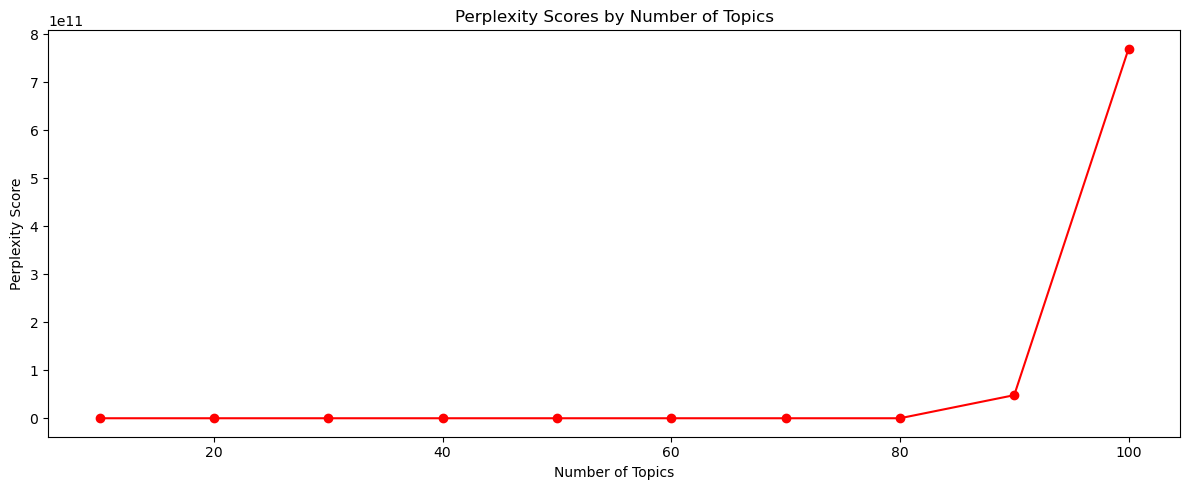

In [91]:
# Example coherence and perplexity scores for demonstration purposes
topics_range = range(10, 101, 10)

plt.figure(figsize=(12, 5))
plt.plot(topics_range, perplexity_scores, marker='o', color='r')
plt.title('Perplexity Scores by Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')

plt.tight_layout()
plt.show()

### Examining LDA outcome

In [92]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(doc_term_matrix)

# Assuming 'lda' is your trained LDA model and 'vectorizer' is your CountVectorizer
feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, no_top_words=10)


Topic 0:
feat remix tonight da gon que dance lights friend power
Topic 1:
love remix mix version world dream sweet man again one
Topic 2:
my way remix rock night feat mix mind version money
Topic 3:
remaster remix feat road wild amor woman wan party tiësto
Topic 4:
remix feat my fire heart version te run days go
Topic 5:
mix back got remix get feat paradise album be version
Topic 6:
feat me light mix version remix baby remastered big drake
Topic 7:
mix boy girl feat song remix hot dreams no heaven
Topic 8:
la feat remix day life mix girls rain people ride
Topic 9:
me edit radio love remix mix down time el your


### Topic Probability

In [93]:
def assign_topic_probabilities_to_documents(lda_model, doc_term_matrix):
    # Get the topic distribution for each document
    topic_distributions = lda_model.transform(doc_term_matrix)

    return topic_distributions

# Applying the function
document_topics_probs = assign_topic_probabilities_to_documents(lda, doc_term_matrix)

# Creating a DataFrame from the topic probabilities
topics_df = pd.DataFrame(document_topics_probs, columns=[f'Topic_{i}' for i in range(document_topics_probs.shape[1])])

# Concatenating the topic probabilities DataFrame with the original DataFrame
df = pd.concat([df, topics_df], axis=1)


### Assign topics to original df

In [95]:
def assign_topics_to_documents(lda_model, doc_term_matrix):
    # Get the topic distribution for each document
    topic_distributions = lda_model.transform(doc_term_matrix)

    # Assign the most dominant topic to each document
    dominant_topic = np.argmax(topic_distributions, axis=1)
    return dominant_topic

# Applying the function
document_topics = assign_topics_to_documents(lda, doc_term_matrix)

# Adding the dominant topic to the original DataFrame
df['Dominant_Topic'] = document_topics

### Coherence scores

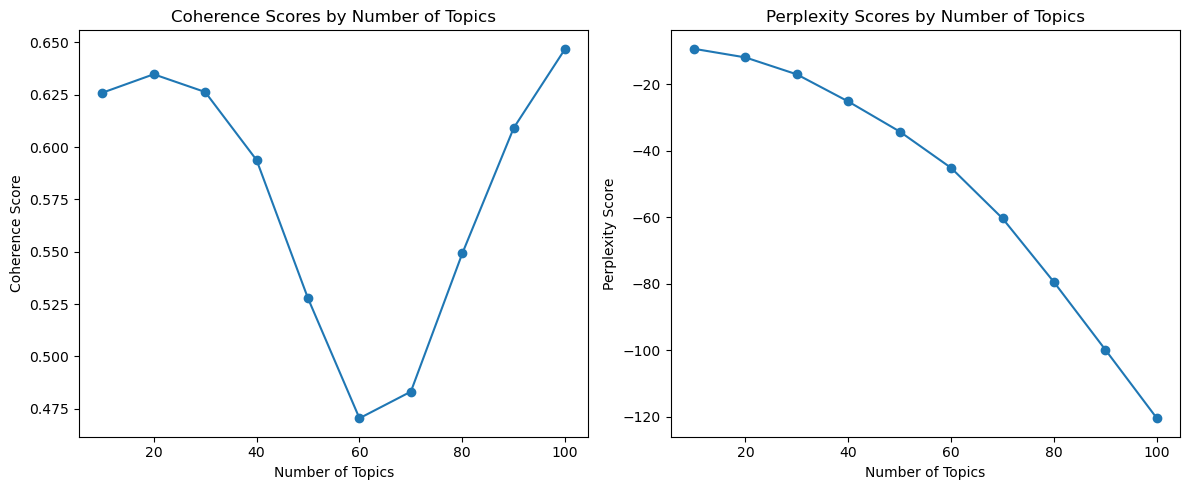

In [101]:
# Function to preprocess text
def preprocess(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in gensim.utils.simple_preprocess(text) if word not in stop_words]

# Assuming 'documents' is your list of documents
processed_docs = [preprocess(doc) for doc in track_name]

# Create Dictionary and Corpus
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

topics_range = range(10, 101, 10)
coherence_scores = []
perplexity_scores = []

for num_topics in topics_range:
    lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=42)

    # Compute Coherence Score
    coherence_model = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

    # Compute Perplexity Score
    perplexity_scores.append(lda_model.log_perplexity(corpus))

# Plotting
plt.figure(figsize=(12, 5))

# Plot Coherence Score
plt.subplot(1, 2, 1)
plt.plot(topics_range, coherence_scores, marker='o')
plt.title('Coherence Scores by Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')

# Plot Perplexity Score
plt.subplot(1, 2, 2)
plt.plot(topics_range, perplexity_scores, marker='o')
plt.title('Perplexity Scores by Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')

plt.tight_layout()
plt.show()